In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# -- KONSTANTER --
G = 6.67430e-11       # Gravitasjonskonstanten (SI)
M_moon = 7.342e22     # Månens masse, kg
mu_moon = G * M_moon  # Månens standard grav.param, m^3/s^2

R_moon = 1737e3       # Månens radius, meter
J2_moon = 2.032e-4    # Månens J2-koeffisient (omtrentlig)

M_earth = 5.972e24          # Jordens masse, kg
R_earth_moon = 384400e3     # Avstand Jorden–Månen, meter
n_earth = np.sqrt(G * M_earth / R_earth_moon**3)  # "Mean motion" Jordas tredjekroppsforstyrrelse

P_solar = 4.56e-6      # Solstrålingstrykk ved 1 AU, N/m^2
U = 12                # Størrelsesfaktor for satellittens tverrsnittsareal
A_satellite = U*0.1*0.1      # Tverrsnittsareal, m^2
m_satellite = 100.0   # Satellittmasse, kg
c_r = 1.2              # Refleksjonskoeffisient for SRP

# -- STARTVERDIER (SI-enheter) --
a0 = R_moon + 50e3     # Semi-major axis = 50 km over månens overflate, meter
e0 = 0.01              # Eksentrisitet
i0 = np.radians(90.0)  # 90 graders inklinasjon
Ω0 = np.radians(10.0)  # RAAN = 10 grader
ω0 = np.radians(0.0)   # Argument of perigee = 0 grader

# -- TIDSOPPSETT --
years = 5
t_total = years * 365.25 * 86400   # 5 år i sek
t_eval = np.arange(0, t_total, 86400)  # Én dag mellom hver utregning

# -- SLÅ AV/PÅ FORSTYRRELSER --
USE_J2       = 1
USE_THIRDBODY= 1
USE_SRP      = 1

# -------------------------------------------------------------------
#   DERIVERTE-FUNKSJON:  d/dt av [a, e, i, Ω, ω]
# -------------------------------------------------------------------
def orbital_element_derivs(t, y, params):
    """
    y = [a (m), e, i (rad), Omega (rad), omega (rad)]
    Returnerer [da/dt, de/dt, di/dt, dOmega/dt, domega/dt].
    """
    (mu, J2, R, nE, psr, Asat, msat, cr, use_j2, use_3rd, use_srp) = params
    
    a, e, inc, Omega, omega = y
    
    # Sikkerhetsjekk på a og e for å unngå negative eller meningsløse verdier
    if a <= R_moon:  # Stopp hvis den "kolliderer" med Månen
        return [0, 0, 0, 0, 0]
    if e < 0:
        e = 0

    n = np.sqrt(mu / a**3)         # Mean motion
    p = a * (1 - e**2)             # Semi-latus rectum

    # -- Start med null endringer --
    da_dt = 0.0
    de_dt = 0.0
    di_dt = 0.0
    dOmega_dt = 0.0
    domega_dt = 0.0

    # -----------------------------------------------------
    # 1) Tolegeme-dynamikk: 
    #    I rent tolegeme-tilfelle er a, e, i, Omega, omega
    #    konstante (ingen sekulære endringer) => 0.
    #    Derfor har vi ingen oppdatering her. 
    # -----------------------------------------------------

    # -----------------------------------------------------
    # 2) J2-PERTURBASJON
    #    Bruk standard sekulære formler (forenklet):
    #    di/dt = 0  (ofte liten for nær-sirkulære baner)
    #    dOmega/dt = -1.5 * J2 * (R^2/p^2) * n * cos i
    #    domega/dt = 0.75 * J2 * (R^2/p^2) * n (5 cos^2 i - 1)
    # -----------------------------------------------------
    if use_j2:
        # Eventuelt sett di/dt = 0 for enkelhet
        di_dt_j2 = 0.0
        
        dOmega_dt_j2 = -1.5 * J2 * (R**2 / p**2) * n * np.cos(inc)
        domega_dt_j2 = 0.75 * J2 * (R**2 / p**2) * n * (5.0 * np.cos(inc)**2 - 1.0)
        
        di_dt     += di_dt_j2
        dOmega_dt += dOmega_dt_j2
        domega_dt += domega_dt_j2

    # -----------------------------------------------------
    # 3) TREDJEKROPPS-FORSTYRRELSE (JORDEN)
    #    Forenklet sekulær tilnærming (stor bane -> liten).
    #    di/dt = 0
    #    dOmega/dt = -3 n_earth (R_earth_moon / a)^3 cos i
    #    domega/dt = 1.5 n_earth (R_earth_moon / a)^3 (1 - 3 sin^2 i)
    # -----------------------------------------------------
    if use_3rd:
        di_dt_earth = 0.0
        dOmega_dt_earth = -3.0 * nE * (R_earth_moon / a)**3 * np.cos(inc)
        domega_dt_earth = 1.5 * nE * (R_earth_moon / a)**3 * (1 - 3 * np.sin(inc)**2)
        
        di_dt     += di_dt_earth
        dOmega_dt += dOmega_dt_earth
        domega_dt += domega_dt_earth

    # -----------------------------------------------------
    # 4) SOLSTRÅLINGSTRYKK (SRP)
    #    Forenklet formel:
    #    a_srp = (P_solar * A_sat * c_r) / m_sat   (antatt radial)
    # -----------------------------------------------------
    if use_srp:
        a_srp = psr * Asat * cr / msat  # m/s^2
        # Bruk "klassiske" sekulære formler (forenklet):
        da_dt_srp = -2.0 * a_srp * (1 + e * np.cos(omega)) / (n * a * (1 - e**2))
        de_dt_srp = a_srp * np.sin(omega) / (n * a * (1 - e**2))
        di_dt_srp = a_srp * np.cos(omega) * np.sin(inc) / (n * a * (1 - e**2))
        dOmega_dt_srp = a_srp * np.sin(omega) / (n * a * np.sin(inc) * (1 - e**2)) if inc != 0 else 0.0
        domega_dt_srp = a_srp * (np.cos(omega) - 2 * e) / (n * a * (1 - e**2))
        
        da_dt     += da_dt_srp
        de_dt     += de_dt_srp
        di_dt     += di_dt_srp
        dOmega_dt += dOmega_dt_srp
        domega_dt += domega_dt_srp

    return [da_dt, de_dt, di_dt, dOmega_dt, domega_dt]

# -------------------------------------------------------------------
# KJØR SIMULASJON (med solve_ivp)
# -------------------------------------------------------------------
# Startvektor y0:
y0 = [a0, e0, i0, Ω0, ω0]

# Parametere som sendes til ODE-funksjonen
params = (
    mu_moon,     # mu
    J2_moon,     # J2
    R_moon,      # R (Månens radius)
    n_earth,     # n_earth
    P_solar, A_satellite, m_satellite, c_r,
    USE_J2, USE_THIRDBODY, USE_SRP
)

# Kjør solve_ivp med en litt streng toleranse, 
# og la den evaluere på t_eval for daglig output
sol = solve_ivp(
    fun=lambda t, y: orbital_element_derivs(t, y, params),
    t_span=(0, t_total),
    y0=y0,
    t_eval=t_eval,
    method='RK45',  # 4./5. ordens Runge-Kutta
    rtol=1e-9,
    atol=1e-12
)

# Hent ut resultater
t_sol = sol.t
a_sol     = sol.y[0]
e_sol     = sol.y[1]
i_sol     = sol.y[2]
Omega_sol = sol.y[3]
omega_sol = sol.y[4]

# "Wrap" vinkler til [0, 2π) for pen plotting
i_sol_mod     = (i_sol     % (2*np.pi))
Omega_sol_mod = (Omega_sol % (2*np.pi))
omega_sol_mod = (omega_sol % (2*np.pi))

# Konverter radianer -> grader
i_deg     = np.degrees(i_sol_mod)
Omega_deg = np.degrees(Omega_sol_mod)
omega_deg = np.degrees(omega_sol_mod)

# Konverter a fra meter til km
a_km = a_sol / 1e3

# Konverter tid fra sek til år
t_years = t_sol / (86400.0 * 365.25)

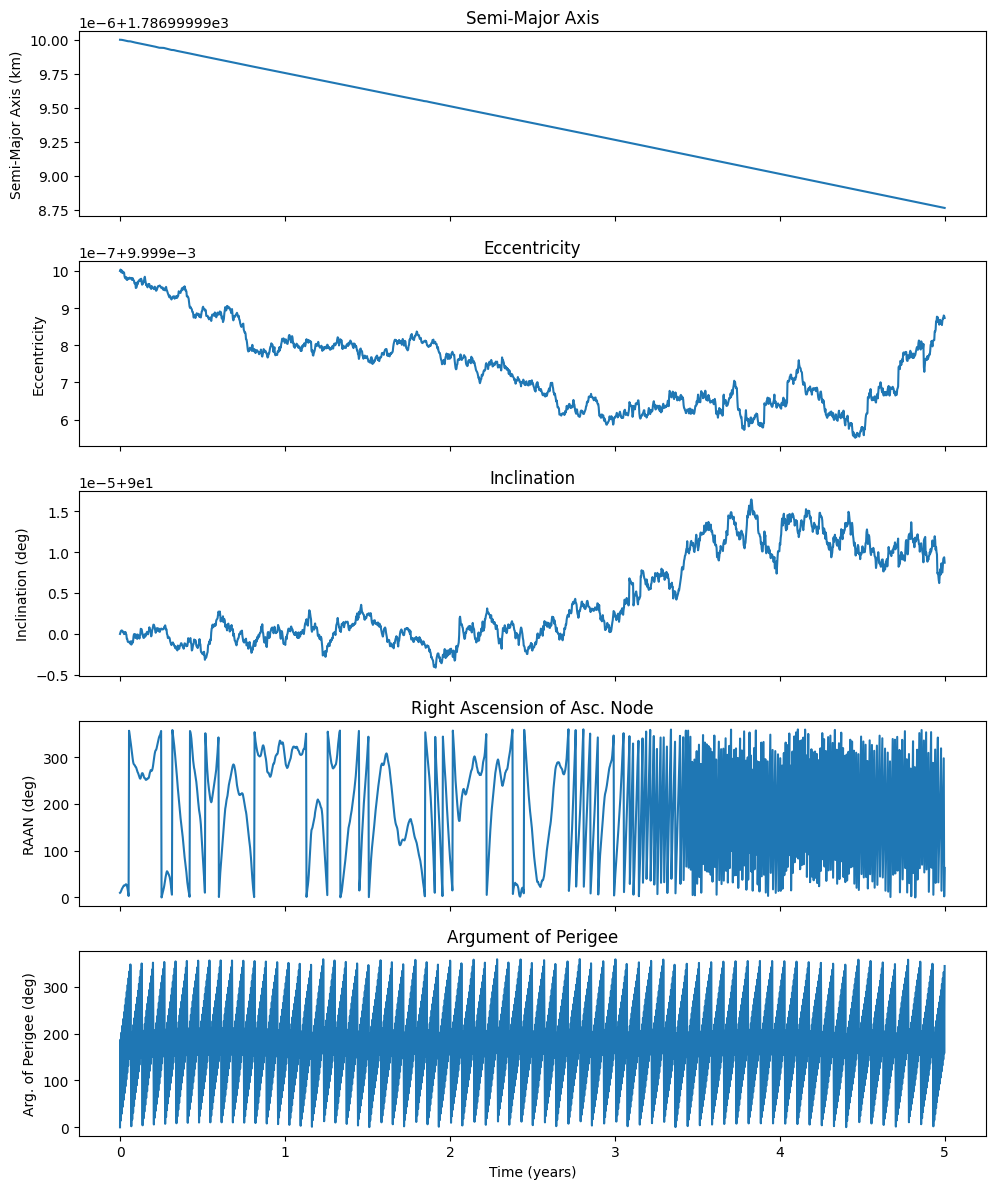

In [15]:
# -------------------------------------------------------------------
# Plotter resultatene
# -------------------------------------------------------------------
fig, axs = plt.subplots(5, 1, figsize=(10, 12), sharex=True)

# Semi-Major Axis
axs[0].plot(t_years, a_km)
axs[0].set_ylabel("Semi-Major Axis (km)")
axs[0].set_title("Semi-Major Axis")

# Eccentricity
axs[1].plot(t_years, e_sol)
axs[1].set_ylabel("Eccentricity")
axs[1].set_title("Eccentricity")

# Inclination
axs[2].plot(t_years, i_deg)
axs[2].set_ylabel("Inclination (deg)")
axs[2].set_title("Inclination")

# RAAN
axs[3].plot(t_years, Omega_deg)
axs[3].set_ylabel("RAAN (deg)")
axs[3].set_title("Right Ascension of Asc. Node")

# Argument of Perigee
axs[4].plot(t_years, omega_deg)
axs[4].set_ylabel("Arg. of Perigee (deg)")
axs[4].set_title("Argument of Perigee")
axs[4].set_xlabel("Time (years)")

plt.tight_layout()
plt.show()